# House Pricing Prediction


## Project Goal

The goal of the present project is to predict the house sale's price using the Ames housing dataset (https://www.kaggle.com/c/house-prices-advanced-regression-techniques). 
I would also advise you to take a look at these two kernels which greatly helped me troughout the project:
* https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python by Pedro Marcelino
* https://www.kaggle.com/johnwill225/extensive-exploratory-data-analysis/notebook by John Willson

Questions are always welcome, leave an upvote if you enjoyed it!

 
## Table of Contents

1. Dataset Overview
2. Exploratory Data Analysis
3. Handling Missing Data
4. Feature Transformation
5. Model Training
6. Prediction
7. Submission
8. Conclusions


José Guerra - 2020

In [185]:
#importing necessary models and libraries

#Preprocessing tools
import pandas as pd
import numpy as np
import scipy
import patsy

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#Math tools
from scipy import stats
from scipy.stats import skew,norm,chisquare  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols


#Visualizing tools
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


#ML Algoirthm
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
import sklearn.linear_model as linear_model
from sklearn import svm
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from mlxtend.regressor import StackingCVRegressor

# 1. Dataset Overview

This dataset contains 79 independent variables which describe almost every aspect of a house. Ultimately we want to predict on the SalePrice (our dependent variable) based on the remaining ones.

In [64]:
# load the train set
df_train = pd.read_csv('input/train.csv')

# Check sample size, features, null-values and types
df_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

#### Observations

- After a brief inspection on all the variables in the dataset, there are definetly a few features that stand out to me as possibily having more impact on the final SalePrice than others. 

- MSZoning (industrial area, residencial area, etc), Neighborhood, OverallQual, TotalBsmtSF (basement squared feet), YearBuilt, GarageCars (how many cars ), GrLivArea (above ground squared feet) are all features that fit this criteria. 

- By looking at the non-null column, there are features that to me do not seem so relevant at first glance such as the type of Alley, FireplaceQU or even the PoolQC (Fireplace and Pool Quality).

- For the independent features 36 of them are numerical and the remain 43 are categorical.

- The ID is not a feature nor has impact in predicting the final sale price, therefore is dropped.

In [65]:
df_train = df_train.drop(columns=['Id'])

# 2. Exploratory Data Analysis

Now that we are more familiar with the nomenclature of this dataset let us analyse the target variable, SalePrice. After that we will also analyse the independent variables and how they relate with our target variable. 

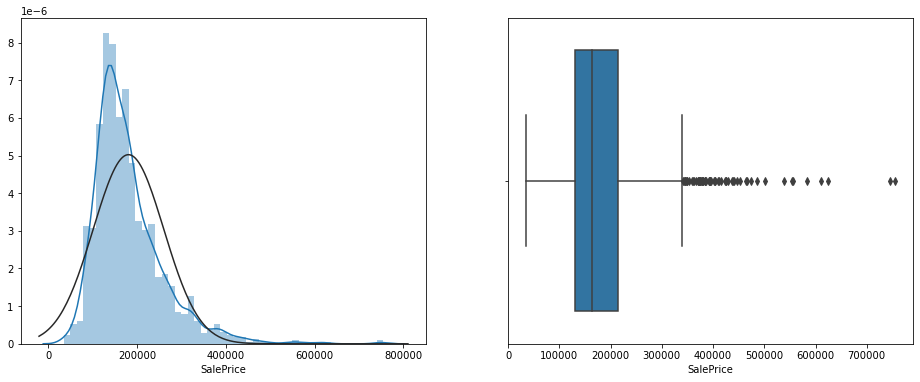

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529
--------------------------------------
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


In [66]:
#descriptive statistics summary
f,ax = plt.subplots(1,2,figsize=(16,6))
sns.distplot(df_train['SalePrice'],fit=norm,ax=ax[0])
sns.boxplot(df_train['SalePrice'])
plt.show()

#skewness and kurtosis
print("Skewness: {}".format(df_train['SalePrice'].skew()))
print("Kurtosis: {}".format(df_train['SalePrice'].kurt()))
print("--------------------------------------")
print(df_train['SalePrice'].describe())

##### Observations:

- The target variable is not normaly distributed, having positive skewness.

- There are no zero values for SalesPrice which is good, since we would be forced to drop those values.

- There are two values over $ 700000, which might be treated as outliers in further analysis.

Now let us see how the independent features relate with SalePrice. An analysis through all the 79 features is important, as well as making a distinction between the numerical (continuous and discrete) and categorical features using proper enconding. This will hopefully give us a better insight on how data is distributed and its value for computing the target variable.

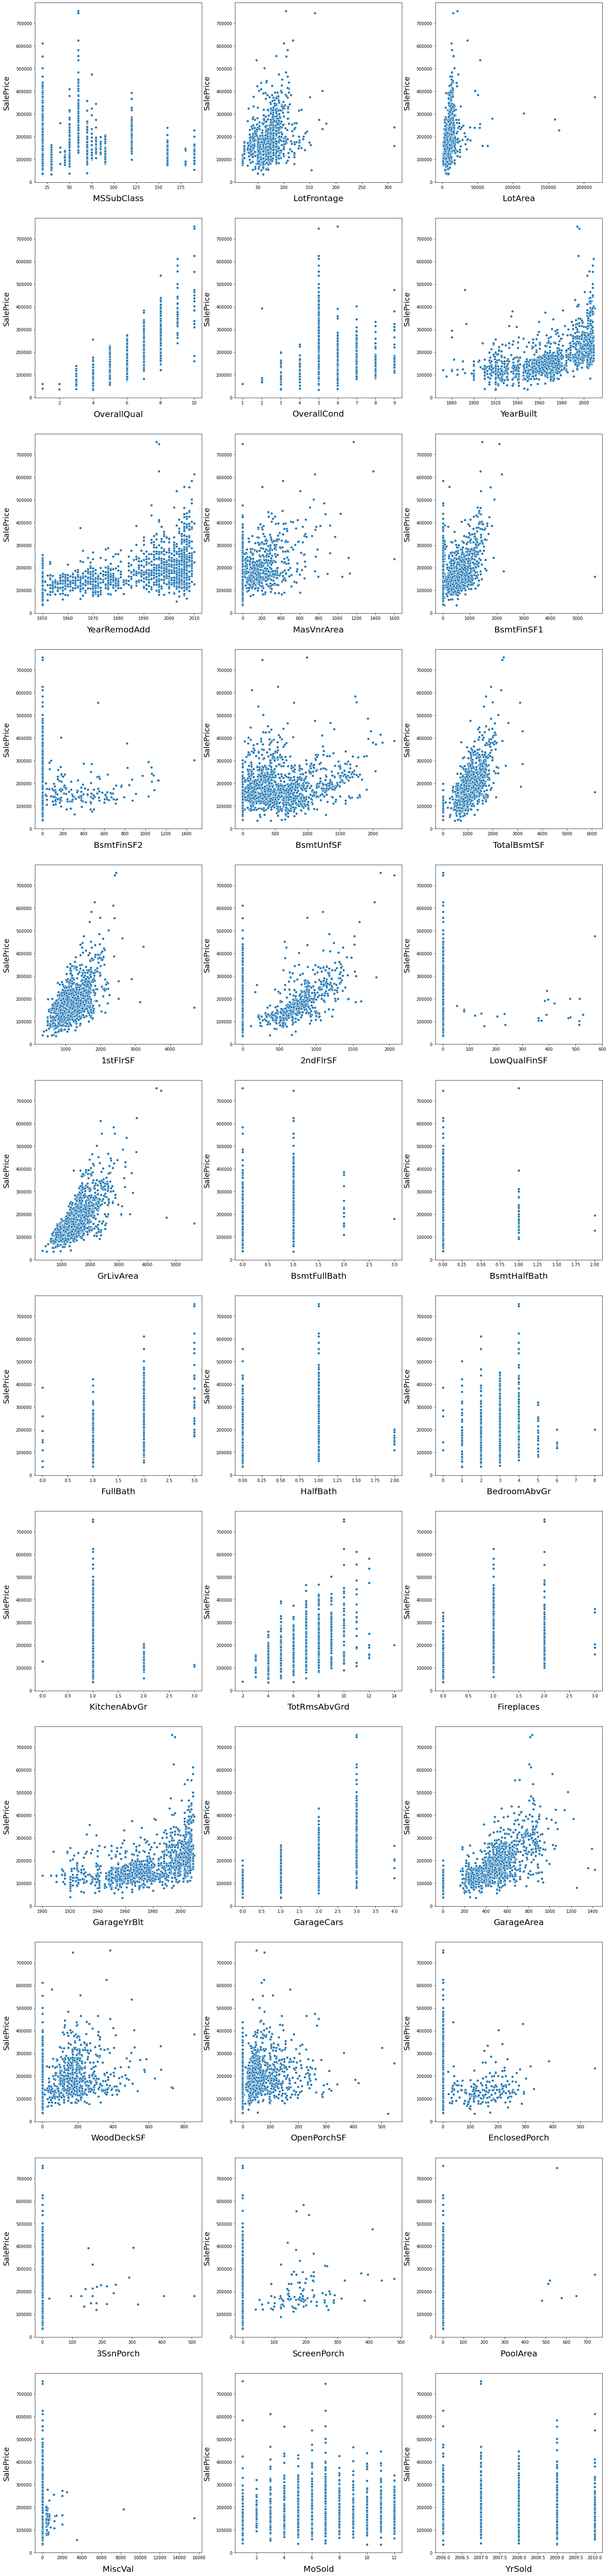

In [67]:
# Finding numeric features
numeric_cols = df_train.select_dtypes(exclude='object').columns
numeric_cols_length = len(numeric_cols)

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(10, 140))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)

# skiped Saleprice feature
for i in range(1,numeric_cols_length):
    feature = numeric_cols[i-1]
    plt.subplot(numeric_cols_length, 3, i)
    sns.scatterplot(x=feature, y='SalePrice', data=df_train)
    plt.xlabel('{}'.format(feature), size=20,labelpad=12.5)
    plt.ylabel('SalePrice', size=18, labelpad=12.5)
           
plt.show()

#### Observations

- MSSubClass (dwelling types) does not seem to play a major role in SalePrice.

- OverallQual appears to have a linear relationship with the target variable. This is also valid for YearBuilt, YearRemodAdd, TotalBsmtSF (total basement squared feet), 1stFlrSF, GrLivArea.

- OverallCond tell us that the SalePrice is likely to be higher if its value is also higher. The same holds for TotalRmsAbvGrd, GarageYrBlt,  GarageCars, GarageArea, LotFontage, LotArea and TotalRmsAbvGr.

- LotFrontage, LotArea, GrLivArea, TotalBsmtSF, 1stFlrSF have outliers on the right side of the scatter plot. 

- A house with a second floor does not necessary mean it costs more but if it has, the larger the area the likelyhood of also costing more.

- The value of miscellaneous features such elevator, 2nd garage etc., do not seem to greatly impact the final SalePrice (with exception for those two outliers).

- Features like EnclosedPorch, ScreenPorch, PoolArea, LowQualFinSf, Fireplaces and even BedroomAbvGr do not seem to impact our dependent variable.

- The year in which the house was sold does not seem to impact the SalePrice, which is curious since the available data includes the 2008 period marked by the real estate crash. 

- We can see a tendency of increased sale price as the year in which the house was built comes forward. The same cannot be said for the year in which was sold though.

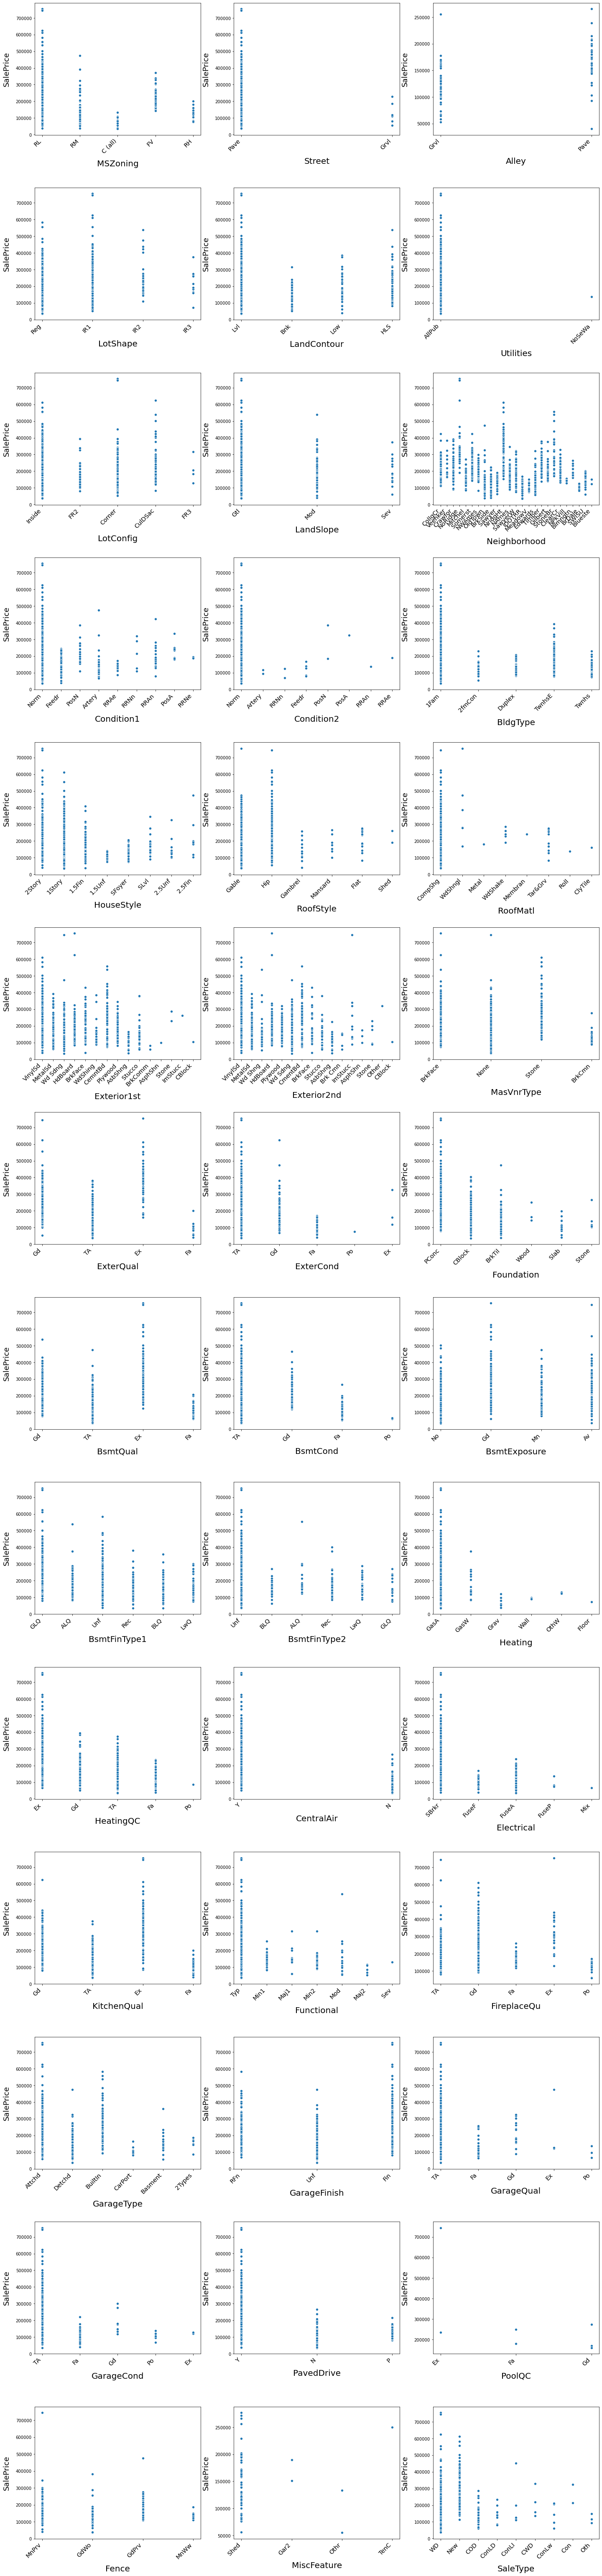

In [68]:
# Finding categorical features
categ_cols = df_train.select_dtypes(exclude=['int64','float64']).columns
categ_cols_length = len(categ_cols)

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(10, 140))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)
plt.subplots_adjust(hspace=0.4)

# This time we include all features
for i in range(1,categ_cols_length):
    feature = categ_cols[i-1]
    plt.subplot(categ_cols_length, 3, i)
    chart = sns.scatterplot(x=feature, y='SalePrice', data=df_train)
    plt.xlabel('{}'.format(feature), size=20,labelpad=12.5)
    plt.ylabel('SalePrice', size=18, labelpad=12.5)
    plt.xticks(
        rotation=45, 
        horizontalalignment='right',
        fontsize='x-large'  
    )
      
plt.show()

#### Observations

- The type of area (MSZoning) and Neighborhood do not seem to have major impact in the SalePrice, which is quite intersting and quite the opposite when one considers what may impact the price of a house.

- We can see that most houses are connected to paved streets and all of them with exception to one have all utilities available.

- The Exterior Quality seems to have a bigger impact on the SalePrice then the Exterior Condition. The same is valid for the basement.

- SalePrice has a tendency to be higher if the house heating quality is better. The same happens for the kithen quality, altough for fireplaces quality this behaviour does not extend.

#### Outliers

As stated before LotFrontage, LotArea, GrLivArea, TotalBsmtSF, 1stFlrSF have outliers on the right side of the scatter plot. For GrLiveArea, the two largest areas are on the lower right side of the plot, which do not follow the tendency at all. This might be because this house is in a farm or some agricultural area and thus its lower price. Either way we will drop them. AFterwards we'll perform the same for the other features if necessary. Note that I'm not normalizing the data and and creating a threshold to drop specific rows, altough that is indeed the correct practice. 


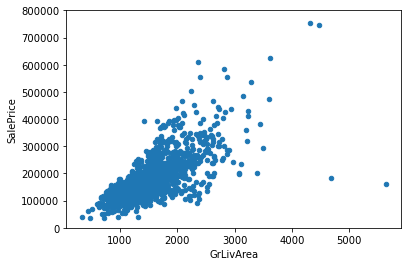

In [69]:
#bivariate analysis SalePrice/grlivarea
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

#deleting points
df_train.sort_values(by = 'GrLivArea', ascending = False)[:2]
df_train = df_train.drop(df_train.index[1298])
df_train = df_train.drop(df_train.index[523])

# You can check how the plot aftwards without those two points

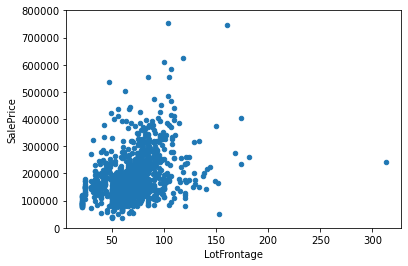

In [70]:
#bivariate analysis SalePrice/LotFrontage
var = 'LotFrontage'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

# deleting point
df_train.sort_values(by = 'LotFrontage', ascending = False)[:2]
df_train.drop(934, inplace=True)

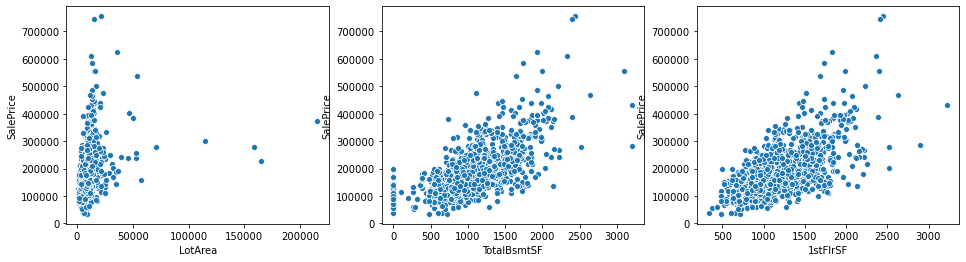

In [71]:
# Lets check the last three feature to see if removing these points had an impact on them

f,ax = plt.subplots(1,3,figsize=(16,4))
sns.scatterplot('LotArea','SalePrice',data=df_train,ax=ax[0])
sns.scatterplot('TotalBsmtSF','SalePrice',data=df_train,ax = ax[1])
sns.scatterplot('1stFlrSF','SalePrice',data=df_train,ax = ax[2])
plt.show()

In [72]:
# For now we'll just remove the point further right on the LotArea plot. On a later analysis we might want to remove more points, but for now lets keep things this way.

df_train.sort_values(by = 'LotArea', ascending = False)[:2]
df_train.drop(313, inplace=True)

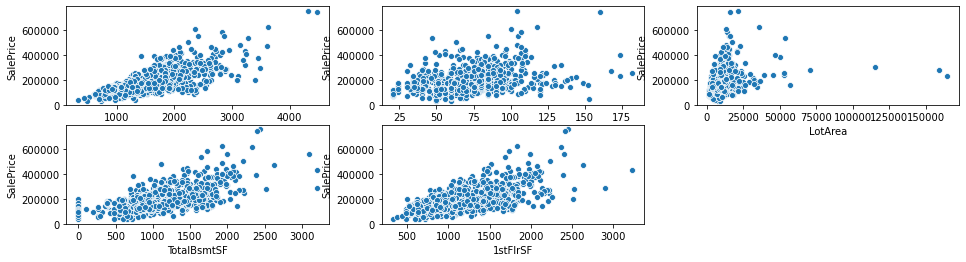

In [73]:
# Updated  plots with removed outliers

f,ax = plt.subplots(2,3,figsize=(16,4))
sns.scatterplot('GrLivArea','SalePrice',data=df_train,ax=ax[0,0])
sns.scatterplot('LotFrontage','SalePrice',data=df_train,ax=ax[0,1])
sns.scatterplot('LotArea','SalePrice',data=df_train,ax=ax[0,2])
sns.scatterplot('TotalBsmtSF','SalePrice',data=df_train,ax = ax[1,0])
sns.scatterplot('1stFlrSF','SalePrice',data=df_train,ax = ax[1,1])
ax[-1, -1].axis('off')
plt.show()

Note that LotArea cleary has outliers when compared to the remain plots, however because we still do not know how that feature relates with SalePrice, we will not discard anymore points at this phase. Talking about relate, let us have a look at correlation!

#### Correlation between variables

Now that we have analysed the SalePrice against all independent features and made some remarks about some of them, it is important to further investigate the relation between these features.

The first step is to verify the correlation between the independent variables and then access both their value in predicting the SalePrice. This analysis will help us better identifying outliers, removing features or joining them as a new independent feature (Feature Selection).

Since we our target variable is numerical, it is good practice to transform the categorical variables into numerical to better access its correlation. It will also help to analyse the categorical data against the remain numerical variables.

We will perform label encoding for this phase, since we are not modeling anything yet. However, notice that when using this encoder the model will misunderstand the data to be in some kind of order, 0 < 1 < 2. The model may derive a correlation like as the street number increases the sale price increases but this clearly may not be the scenario. To overcome this problem, we will later use One Hot Encoder (or dumies variables). 
Nonetheless, for this stage it is preferable to keep the same amount of variables and if anything suspicious pops up in the correlation matrix, we investigate it.

In [74]:
# label enconding categorical features

# Select categorical features from train dataset
categ_label = df_train.select_dtypes(exclude=['int64','float64'])

# Replacing nan (float) with 'NaN' (string) takes into account the missing values 
categ_label[pd.isnull(categ_label)]  = 'NaN'
# display(categ_label.isnull().values.any()) -> Should return False

# Perform enconding
categ_label = categ_label.apply(LabelEncoder().fit_transform)
display(categ_label)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,3,1,1,3,3,0,4,0,5,2,...,1,2,5,5,2,3,4,1,8,4
1,3,1,1,3,3,0,2,0,24,1,...,1,2,5,5,2,3,4,1,8,4
2,3,1,1,0,3,0,4,0,5,2,...,1,2,5,5,2,3,4,1,8,4
3,3,1,1,0,3,0,0,0,6,2,...,5,3,5,5,2,3,4,1,8,0
4,3,1,1,0,3,0,2,0,15,2,...,1,2,5,5,2,3,4,1,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,3,1,1,3,3,0,4,0,8,2,...,1,2,5,5,2,3,4,1,8,4
1456,3,1,1,3,3,0,4,0,14,2,...,1,3,5,5,2,3,2,1,8,4
1457,3,1,1,3,3,0,4,0,6,2,...,1,2,5,5,2,3,0,3,8,4
1458,3,1,1,3,3,0,4,0,12,2,...,1,3,5,5,2,3,4,1,8,4


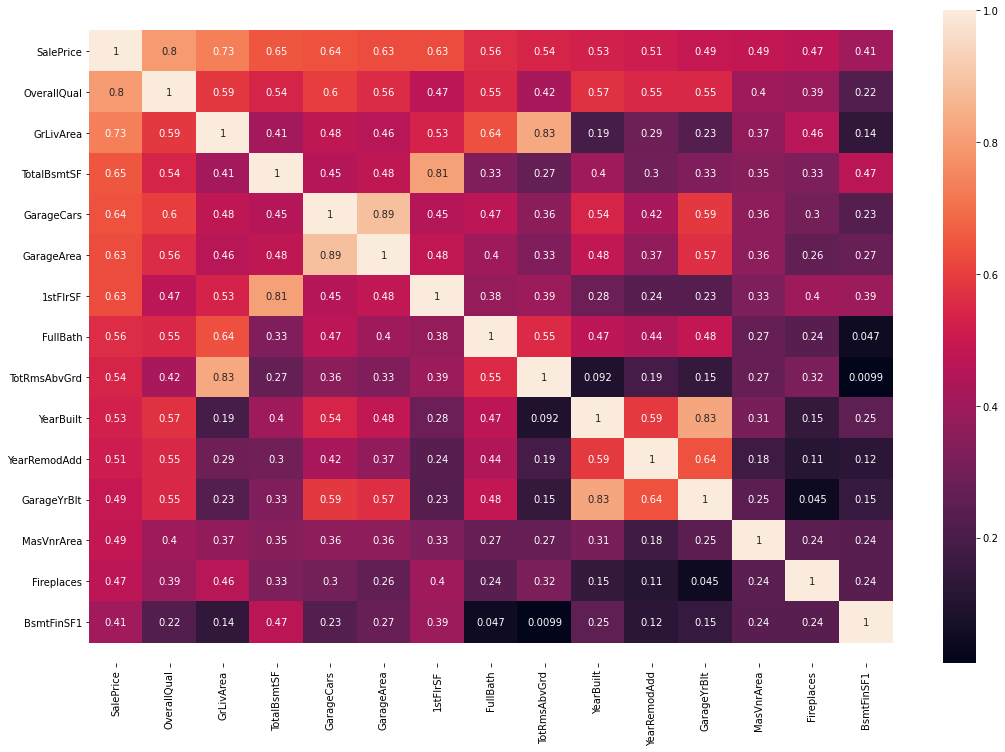

In [75]:
# Create the correlation matrix with labeled features

# for numerical variables we do not need to perform the encoding
numeric_label = df_train.select_dtypes(exclude='object')

# Combine numerical and categorical features in order to create 
corr_features = pd.concat([numeric_label, categ_label],axis=1, sort=False)

# Let us now see how the independent variables relate with SalePrice.
corWithSalePrice = corr_features.corr().nlargest(15,'SalePrice')['SalePrice'].index
f , ax = plt.subplots(figsize = (18,12))
ax = sns.heatmap(corr_features[corWithSalePrice].corr(), annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

# You can also cross check this correlation graph against the one which disregards transformation from categorical to numeric. 
# You will see that for this specific example it will hold the same results.


##### Observations

- Top 5 most correlated features with SalePrice are OverallQual (0.79), GrLivArea (0.71), GarageCars (0.64), GarageArea (0.62) and TotalBsmtSF (0.61).

- GrLivArea and TotRmsAbvGrd are strongly correleated (0.83), which makes sense since as the ground area increases, the count of rooms also increases. We can keep GrLivArea since it has a higher correlation with SalePrice.

- GarageCas and GarageArea are strongly correlated (0.88), meaning that most garage area from the houses can be used to park cars and is indeed its purpose. For the same reason has above, we'll keep GarageCars.

- TotalBsmtSF and 1stFlrSF are strongly correleated (0.82), since houses with garage will in most cases share a very similar area with the first floor / ground floor.

- YearBuilt and GarageYrBlt also share also strongly correlated (0.83), which makes sense since the garage is usually built in the same year as the rest of the house. GarageYrBlt will be dropped.

- Full bathrooms comes in 7th, which is quite interesting verifying that has a higher impact on SalePrice among all the divisions (except for the garage).

- All the top features are numerical, which is not indicative of the relevance of the categorical variables for this dataset. 


However, this is only way of dealing with categorical features to extract meaningful value from our dataset. Another way is to perform ANOVA, which stands for analysis of variance. ANOVA is a form of hypothesis testing in which we accept or reject the null hypothesis. The null hypothesis considers that the independent variable is not statistically significant to impact the dependent variable (basically there is no relation between the two variables). To do that we must first transform our categorical features into dummy variables.

In [76]:
# Get dummy variables
input_vars = pd.get_dummies(df_train.SaleCondition)
display(input_vars.columns)

# Get our target variable
target_var = df_train.SalePrice

# Perform ANOVA
anova_df = pd.concat([target_var, input_vars],axis=1, sort=False)
mod = ols('SalePrice ~ Abnorml + AdjLand + Alloca + Family + Normal + Partial', data=anova_df).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)


Index(['Abnorml', 'AdjLand', 'Alloca', 'Family', 'Normal', 'Partial'], dtype='object')

                sum_sq      df           F        PR(>F)
Abnorml   1.121022e+08     1.0    0.020588  8.859265e-01
AdjLand   9.040710e+09     1.0    1.660375  1.977583e-01
Alloca    7.249862e+09     1.0    1.331476  2.487330e-01
Family    4.372129e+08     1.0    0.080296  7.769365e-01
Normal    1.005912e+11     1.0   18.474114  1.837134e-05
Partial   1.181797e+12     1.0  217.043301  6.953746e-46
Residual  7.895224e+12  1450.0         NaN           NaN


Given the F-value and p-value for the subset of categories within SaleCondition, we can accept the null hypothesis, meaning that there is no statistical significance between SalePrice and SaleCondition. What about Heating Quality for example?

In [77]:
# Get dummy variables
input_vars = pd.get_dummies(df_train.HeatingQC)
display(input_vars.columns)

# Perform ANOVA
anova_df = pd.concat([target_var, input_vars],axis=1, sort=False)
mod = ols('SalePrice ~ Ex + Fa + Gd + Po + TA', data=anova_df).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

Index(['Ex', 'Fa', 'Gd', 'Po', 'TA'], dtype='object')

                sum_sq      df          F        PR(>F)
Ex        3.013285e+11     1.0  59.496069  2.263491e-14
Fa        2.359939e+08     1.0   0.046596  8.291264e-01
Gd        4.158382e+10     1.0   8.210554  4.224769e-03
Po        1.639846e+09     1.0   0.323781  5.694324e-01
TA        1.471374e+10     1.0   2.905167  8.851019e-02
Residual  7.348850e+12  1451.0        NaN           NaN


This times things are a little different. We can see that when the Heating Quality is either Excelent or Good, it has statistically significant impact on SalePrice. This means that we do not accept the null hypothesis for HeatingQC. Again, this is a different approach that give us a more in-depth analysis of our categorical variables. Most of the times, correlation alone is not enough.

Before moving to the missing data, we can discard some of the features that would overfit our model. One way to perform this is to check if data from one feature contains mostly one value. Here we'll place the threshold on 99%, but there is room to change if necessary.

In [78]:
def remove_overfit_features(df,weight):
    overfit = []
    for i in df.columns:
        counts = df[i].value_counts()
        zeros = counts.iloc[0]
        if zeros / len(df) * 100 > weight:
            overfit.append(i)
    overfit = list(overfit)
    return overfit


overfitted_features = remove_overfit_features(df_train,99)
display(overfitted_features)
df_train.drop(overfitted_features,inplace=True,axis=1)

['Street', 'Utilities', 'Condition2', 'PoolArea']

# 3. Handling Missing Data


In this chapter and in the next one we will be working with the full data set, as the processes used are required on both sides. Let us do that and take a look at the joined data. 

In [79]:
# load the test set
df_test = pd.read_csv('input/test.csv')

# Remove Id column
df_test = df_test.drop(columns=['Id'])

# remove overfitted features
def remove_overfit_features(df,weight):
    overfit = []
    for i in df.columns:
        counts = df[i].value_counts()
        zeros = counts.iloc[0]
        if zeros / len(df) * 100 > weight:
            overfit.append(i)
    overfit = list(overfit)
    return overfit
overfitted_features_test = remove_overfit_features(df_test,99)
display(overfitted_features_test)
df_test.drop(overfitted_features_test,inplace=True,axis=1)

# Join train and test data set in order to apply the feature transformation pipeline to the entire dataset
train_features = df_train.drop(['SalePrice'], axis=1)
test_features = df_test
all_features = pd.concat([train_features, test_features]).reset_index(drop=True)

['Street', 'Utilities', 'Heating', 'LowQualFinSF', '3SsnPorch', 'PoolArea']

In [80]:
# List of columns with missing data and its ratio
all_features_na = (all_features.isnull().sum() / len(all_features)) * 100
all_features_na = all_features_na.drop(all_features_na[all_features_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_features_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691252
MiscFeature,96.397942
Alley,93.207547
Fence,80.411664
LowQualFinSF,50.051458
Heating,50.051458
3SsnPorch,50.051458
Condition2,49.948542
FireplaceQu,48.713551
LotFrontage,16.672384


Text(0.5, 1.0, 'Percent missing data by feature')

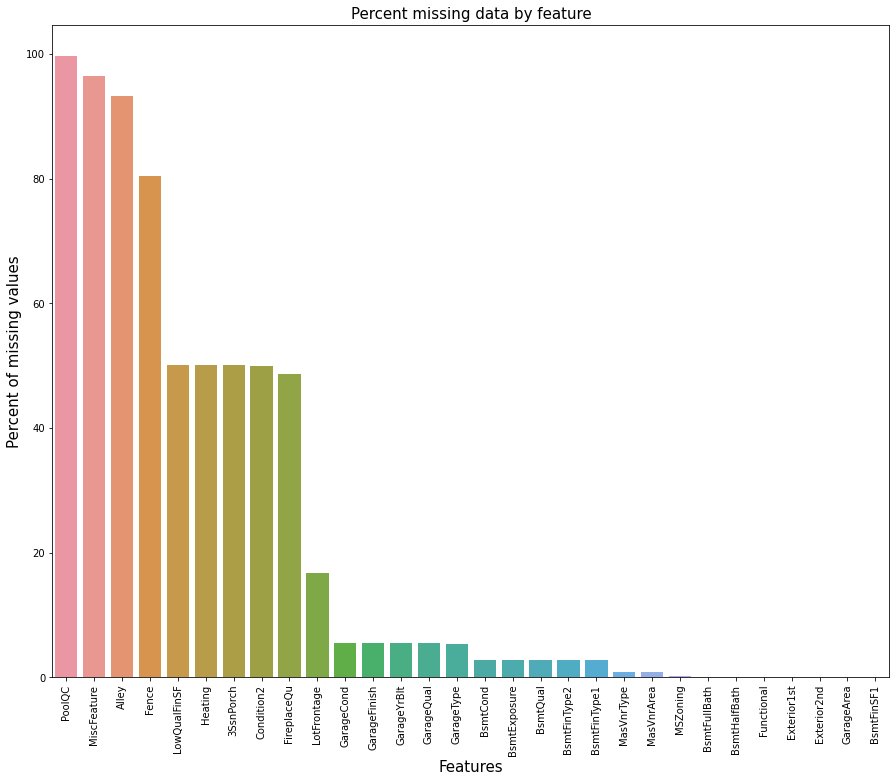

In [81]:
#visualize missing data graphically in percentage
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_features_na.index, y=all_features_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

##### Observations

The complete dataset has mostly null values in features such has PoolQC, MiscFeatures, Alley and Fence. FireplaceQu has around 50% of its values has being null. The first ones seem expected as they are features which most of the houses do not have or are not revelant for the business. 

Features such as 3SsnPorch, LowQualFinSF, Heating and Condition2 all came for droping the overfitted features and this new dataset ended up with the remaining from either the train set or the test set. We previsouly mentioned in the EDA that Heating and SalePrice seem to have a relationship of some sort. Well, that was indeed the case for our train set, but for our test set we found out that most our houses had the same value for heating. When one feature has data on the train set but lacks data on the test set, it is advisable to drop that feature. There are advanced techniques to imput missing values such as KNN but for now we will keep things simple. Nonetheless, this would be a very good alternative if our independent feature had a high correlation with SalePrice.

In [82]:
all_features = all_features.drop(['3SsnPorch','LowQualFinSF','Heating','Condition2'], axis=1)

Let us now impute the missing values of the remaining features. There will be different methods to impute, such as fill with 0's and None's for numeric and categorical values respectively, using mode and and median or see what variables might be related for the specific rows to help us complete the dateset. Variables with more than 80% of missing values will be removed. 

In [83]:
print("Total No. of missing value {} before Imputation".format(sum(all_features.isnull().sum())))

# For SaleType, we use the specific subtype associated with SaleCondition to compute the mode
# We could compute the mode directly, but is important to see if there is a variable that relates to
# our missing value and thus evaluating the data in a smaller subset.
Sale_Condition = all_features[all_features['SaleType'].isnull()]['SaleCondition'].values[0]
fillSaleType = all_features[all_features['SaleCondition'] == Sale_Condition]['SaleType'].mode()[0]
all_features['SaleType'].fillna(fillSaleType,inplace=True)

# The same principle is applied to KitchenQual and KitchenAbvGr
kitchen_grade = all_features[all_features['KitchenQual'].isnull()]['KitchenAbvGr'].values[0]
fillKitchenQual = all_features[all_features['KitchenAbvGr'] == kitchen_grade]['KitchenQual'].mode()[0]
all_features['KitchenQual'].fillna(fillKitchenQual,inplace=True)

# For the next features, we will use the Neighborhood as a reference, since it is common for houses
# in the same neighboorhood to share these characteristics.
Electrical_neighbor = all_features[all_features['Electrical'].isnull()]['Neighborhood'].values[0]
fillElectrical = all_features[all_features['Neighborhood']==Electrical_neighbor]['Electrical'].mode()[0]
all_features['Electrical'].fillna(fillElectrical,inplace=True)

exterior1_neighbor = all_features[all_features['Exterior1st'].isnull()]['Neighborhood'].values[0]
fillExterior1 = all_features[all_features['Neighborhood'] == exterior1_neighbor]['Exterior1st'].mode()[0]
all_features['Exterior1st'].fillna(fillExterior1,inplace=True)

exterior2_neighbor = all_features[all_features['Exterior2nd'].isnull()]['Neighborhood'].values[0]
fillExterior2 = all_features[all_features['Neighborhood'] == exterior1_neighbor]['Exterior1st'].mode()[0]
all_features['Exterior2nd'].fillna(fillExterior2,inplace=True)

bsmt_neighbor = all_features[all_features['BsmtFinSF1'].isnull()]['Neighborhood'].values[0]
fillBsmtFinSf1 = all_features[all_features['Neighborhood'] == bsmt_neighbor]['BsmtFinSF1'].mode()[0]
all_features['BsmtFinSF1'].fillna(fillBsmtFinSf1,inplace=True)

# Note that for LotFrontage we use the median of the values, not the mode
all_features['LotFrontage'] = all_features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# For MSZoning we have 4 missing values, and for each we will associate MSSubClass (type of dwelling).
all_features['MSZoning'] = all_features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
       
# For the remaning numerical features we'll replace nan by 0
numeric_cols = all_features.select_dtypes(include='number').columns
all_features[numeric_cols] = all_features[numeric_cols].fillna(0)

# For the remaning categorical features we'll replace nan by 'None'
categorical_cols =  all_features.select_dtypes(include='object').columns
all_features[categorical_cols] = all_features[categorical_cols].fillna('None')

# Features to be dropped
# PoolQC, MiscFeature, Alley,Fence - all with close to 80% of missing values or more.
# GarageYrBlt will be dropped as there is no other year of construction to be associated with 
# and imputing 0 or mode or mean does not make any sense
all_features.drop(['PoolQC','MiscFeature','Alley', 'Fence','GarageYrBlt'],inplace=True,axis=1)
    
print("Total No. of missing value {} after Imputation".format(sum(all_features.isnull().sum())))


Total No. of missing value 13948 before Imputation
Total No. of missing value 0 after Imputation


We have successfully manage to impute the missing values of this dataset. Along the way we discarded features which had high percentage of missing values (> ~80%) or had the majority of its information represented by a single value (which can induce a model to overfit). It is now time to prepare the dataset for model training.

# 4. Feature Transformation

In this chapter we will transform the features in order to better prepare the data for model training. Tasks as normalize skewed data and create features from existent will also be conducted in this chapter.

The first step is to find the skewed features and perform logarithmic transformation (for right-skewed data!). The logarithmic function essentially de-emphasizes very large values. Now, in a right-skewed distribution you have a few very large values. The log transformation essentially reels these values into the center of the distribution making it look more like a Normal distribution. 

The reason you normalize the features (both dependent and independent) is to produce the smallest error possible when making a prediction without overfitting the model. The prediction error is one component of the regression formula:

Y = Coefficient * X + Intercept + Prediction Error

Why is it important? Here's a excerpt retrived from an interesting post on towardsdatascience.
"For example, you are trying to analyse which variables are useful to predict housing price and you have selected the factors based on 5% significance level. If the distribution of error significantly deviates from the mean 0 normal distribution, the factors you choose to be significant may not actually be significant enough to contribute to housing price changes. However, it would not affect your prediction if you just want to get the prediction based on lowest mean squared error."

Link: https://towardsdatascience.com/is-normal-distribution-necessary-in-regression-how-to-track-and-fix-it-494105bc50dd
Here is another one: https://stats.stackexchange.com/questions/107610/what-is-the-reason-the-log-transformation-is-used-with-right-skewed-distribution
Annnd another one: https://datascience.stackexchange.com/questions/40089/what-is-the-reason-behind-taking-log-transformation-of-few-continuous-variables

"Logarithmic transformation is a convenient means of transforming a highly skewed variable into a more normalized dataset. When modeling variables with non-linear relationships, the chances of producing errors may also be skewed negatively. In theory, we want to produce the smallest error possible when making a prediction, while also taking into account that we should not be overfitting the model. Overfitting occurs when there are too many dependent variables in play that it does not have enough generalization of the dataset to make a valid prediction. Using the logarithm of one or more variables improves the fit of the model by transforming the distribution of the features to a more normally-shaped bell curve." -https://dev.to/rokaandy/logarithmic-transformation-in-linear-regression-models-why-when-3a7c

##### Skewed Features

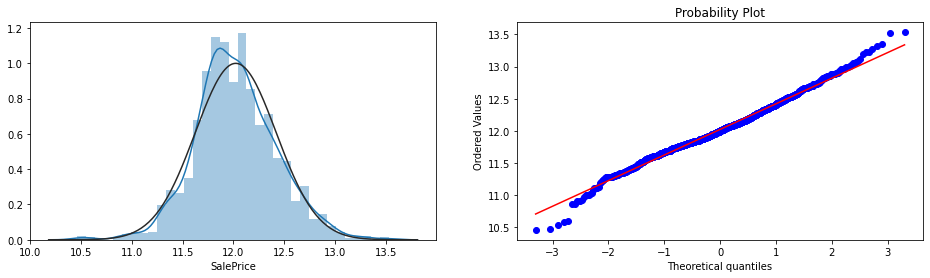

Skewness: 0.12191908332944387
Kurtosis: 0.8144502189272806


In [84]:
# Remember SalePrice? It was right-skewed. Lets change that
#Logarithmic transformation
y = np.log1p(df_train['SalePrice'])
train_labels = y

f,ax = plt.subplots(1,2,figsize=(16,4))
sns.distplot(y,fit=norm,ax=ax[0])
stats.probplot(y,plot=plt)
plt.show()

#skewness and kurtosis
print("Skewness: {}".format(y.skew()))
print("Kurtosis: {}".format(y.kurt()))

In [85]:
# Let us now go for the independent features

# The following numeric feature do not have an ordering value, meaning that analysing its distribution
# does not have any meaning. They will be converted into strings
all_features['MSSubClass'] = all_features['MSSubClass'].apply(str)
all_features['YrSold'] = all_features['YrSold'].astype(str)
all_features['MoSold'] = all_features['MoSold'].astype(str)

# Filter the right skewed features
numeric = all_features.select_dtypes(include='number').columns
skew_features = all_features[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

There are 22 numerical features with Skew > 0.5 :


MiscVal          21.932147
LotArea          10.392981
KitchenAbvGr      4.298845
BsmtFinSF2        4.159555
EnclosedPorch     4.000796
ScreenPorch       3.943508
BsmtHalfBath      3.928397
MasVnrArea        2.620646
OpenPorchSF       2.528573
WoodDeckSF        1.843954
dtype: float64

In [86]:
# Normalize skewed features using boxcox
for i in skew_index:
    all_features[i] = boxcox1p(all_features[i], boxcox_normmax(all_features[i] + 1))

In [87]:
# is there any left skewed data?
negative_skew = skew_features[skew_features < -0.5]
negative_skew_index = negative_skew.index

print("There are {} numerical features with Skew < -0.5 :".format(negative_skew.shape[0]))
skew_features.tail(5)

There are 1 numerical features with Skew < -0.5 :


OverallQual     0.190757
FullBath        0.166844
GarageCars     -0.218630
YearRemodAdd   -0.450453
YearBuilt      -0.599621
dtype: float64

Note that for the left skewed data we won't make any transformations since normal distribution for this feature does not have meaning (it is the same analagy used for YrSold and MoSold)

###### Transforming numerical variables that are really categorical

In [88]:
#MSSubClass=The building class
all_features['MSSubClass'] = all_features['MSSubClass'].apply(str)

#Year and month sold are transformed into categorical features.
all_features['YrSold'] = all_features['YrSold'].astype(str)
all_features['MoSold'] = all_features['MoSold'].astype(str)

##### Feature Creation

In [89]:
# One feature that should be interesting to see is YearSinceRemodelation and how impactful it is against the two features used separately
all_features['YearsSinceRemodel'] = all_features['YrSold'].astype(int) - all_features['YearRemodAdd'].astype(int)
all_features['YearsSinceRemodel'] = all_features['YearsSinceRemodel'].astype(str)

# Total Sqfootage of the house 
all_features['TotalSF'] = all_features['TotalBsmtSF'] + all_features['1stFlrSF'] + all_features['2ndFlrSF']

# Total Home quality
all_features['Total_Home_Quality'] = all_features['OverallQual'] * all_features['OverallCond']


##### Feature Tranformation

In [90]:
# There is a natural order in their values for few categories, so converting them to numbers gives more meaning
quality_map = {'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
quality_cols = ['BsmtQual', 'BsmtCond','ExterQual', 'ExterCond','FireplaceQu','GarageQual', 'GarageCond','KitchenQual','HeatingQC']
for col in quality_cols:
    all_features[col] = all_features[col].replace(quality_map)

all_features['BsmtExposure'] = all_features['BsmtExposure'].replace({"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3})

all_features["PavedDrive"] =all_features["PavedDrive"].replace({"N" : 0, "P" : 1, "Y" : 2})

bsmt_ratings = {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6}
bsmt_col = ['BsmtFinType1','BsmtFinType2']
for col in bsmt_col:
    all_features[col] = all_features[col].replace(bsmt_ratings)

In [92]:
all_features = pd.get_dummies(all_features).reset_index(drop=True)

In [93]:
X = all_features.iloc[:len(train_labels), :]
X_test = all_features.iloc[len(train_labels):, :]

overfitted_features = remove_overfit_features(X,99)

X = X.drop(overfitted_features, axis=1)
X_test = X_test.drop(overfitted_features, axis=1)

# Model Training

In [94]:
# Relavance of cross validation (in this case we use KFold cross-validation)
# https://stackabuse.com/cross-validation-and-grid-search-for-model-selection-in-python/

kf = KFold(n_splits=12, random_state=42, shuffle=True)

# Define error metrics
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, train_labels, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

In [101]:
# Ridge Regressor
# Ridge regression was proposed as an alternative method to ordinary least squares (OLS), 
# that trades bias for variance to improve the mean square error (RMSE).This method is particularly 
# useful when the  OLS is unstable (high variance). This can happen in presence of high collinearity 
# between the predictors or when the number of predictors is large in comparison to the number of observations.
# ridge regression assumes the predictors are standardized and the response is centered!

# https://www.datacamp.com/community/tutorials/tutorial-ridge-lasso-elastic-net#comments
# https://bookdown.org/tpinto_home/Regularisation/ridge-regression.html
# https://rpubs.com/danaecarrerasgarcia/535667#:~:text=The%20RMSE%20is%20computed%20using,to%20as%20the%20training%20RMSE.&text=In%20some%20settings%2C%20we%20may,to%20train%20the%20statistical%20method.

ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

# Lasso Regressor
# Lasso regression, which penalizes the sum of absolute values of the coefficients (L1 penalty).
# Different from ridge, which penalizes sum of squared coefficients (L2 penalty)
lasso_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
lasso = make_pipeline(RobustScaler(), LassoCV(alphas=lasso_alphas, cv=kf))


# Lasso tends to do well if there are a small number of significant parameters and the others 
# are close to zero (ergo: when only a few predictors actually influence the response).
# Ridge works well if there are many large parameters of about the same value 
# (ergo: when most predictors impact the response).

# You can also check out Elastic Net, which combines these two regressors.

In [96]:
# Support Vector Regressor
# SVR is an algorithm that allows us to choose how tolerant we are of errors, both through an acceptable
# error margin(ϵ) and through tuning our tolerance of falling outside that acceptable error rate

def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10, 20, 30, 40, 50]
    gammas = [0.0001, 0.0002, 0.0003, 0.001, 0.002, 0.003, 0.1, 0.2, 0.3, 1]
    epsilons = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
    param_grid = {'C': Cs, 'gamma' : gammas, 'epsilon' : epsilons}
    grid_search = GridSearchCV(svm.SVR(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

svc_param_selection(X,train_labels,kf)
# https://www.youtube.com/watch?v=_PwhiWxHK8o&t=714s&ab_channel=MITOpenCourseWare
# https://towardsdatascience.com/a-guide-to-svm-parameter-tuning-8bfe6b8a452c#:~:text=C%3A%20The%20Penalty%20Parameter,on%20both%20sides%20as%20possible.
# https://scikit-learn.org/stable/modules/svm.html#svm-kernels
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
# https://medium.com/@aneesha/svm-parameter-tuning-in-scikit-learn-using-gridsearchcv-2413c02125a0
# https://cs.stanford.edu/people/karpathy/svmjs/demo/
# https://svmlearning.com/parameters/

{'C': 1, 'epsilon': 0.01, 'gamma': 0.0001}

In [110]:
# run svr with best parameters
svr = make_pipeline(RobustScaler(), SVR(C= 1, epsilon= 0.01, gamma=0.0001))

In [200]:
# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)

# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01, n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006,random_state=42)

# StackingCVRegressor 
# Stacking regression is a method for forming linear combinations of different predictors to give improved prediction accuracy.
# The idea is to use cross-validation data and least squares under non-negativity constraints to determine the coefficients in 
# the combination.
stackReg = StackingCVRegressor(regressors=(xgboost, svr, ridge, lasso, gbr),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True,random_state=42)

# Prediction

In [102]:
model_score = {}

score = cv_rmse(ridge)
ridge_model_full_data = ridge.fit(X, train_labels)
print("ridge: {:.4f}".format(score.mean()))
model_score['ridge'] =  score.mean()

ridge: 0.1106


In [103]:
score = cv_rmse(lasso)
lasso_model_full_data = lasso.fit(X, train_labels)
print("lasso: {:.4f}".format(score.mean()))
model_score['lasso'] =  score.mean()

lasso: 0.1103


In [111]:
score = cv_rmse(svr)
svr_model_full_data = svr.fit(X, train_labels)
print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
model_score['svr'] = score.mean()

SVR: 0.1094 (0.0175)


In [114]:
score = cv_rmse(gbr)
gbr_model_full_data = gbr.fit(X, train_labels)
print("gbr: {:.4f}".format(score.mean()))
model_score['gbr'] =  score.mean()

gbr: 0.1110


In [120]:
score = cv_rmse(xgboost)
xgb_model_full_data = xgboost.fit(X, train_labels)
print("xgboost: {:.4f})".format(score.mean()))
model_score['xgb'] = score.mean()

[22:22:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:17

In [202]:
stack_reg_model = stackReg.fit(np.array(X), np.array(train_labels))

In [149]:
def blended_predictions(X,weight):
    return ((weight[0] * ridge_model_full_data.predict(X)) + \
            (weight[1] * ridge_model_full_data.predict(X)) + \
            (weight[2] * svr_model_full_data.predict(X)) + \
            (weight[3] * gbr_model_full_data.predict(X)) + \
            (weight[4] * xgb_model_full_data.predict(X)) + \
            (weight[5] * stack_reg_model.predict(np.array(X))))

In [160]:
# Blended model predictions
blended_score = rmsle(train_labels, blended_predictions(X,[0.1,0.1,0.3,0.1,0.1,0.3]))
print("blended score: {:.4f}".format(blended_score))
model_score['blended_model'] =  blended_score

blended score: 0.0703


In [176]:
pd.Series(model_score).sort_values(ascending=True)

blended_model    0.070314
svr              0.109409
lasso            0.110268
ridge            0.110560
gbr              0.110959
xgb              0.114307
dtype: float64

In [177]:
# We will now compare our two best models, svr and the blended model

# SVR Prediction
svr_prediction = np.expm1(svr.predict(X_test))

# Blended Prediction
blended_prediction = np.expm1(blended_predictions(X_test,[0.15,0.15,0.2,0.1,0.1,0.3]))

# Top 4 percent Prediction
submission_top4percent = pd.read_csv("submission_top4percent.csv")
top_prediction = submission_top4percent["SalePrice"].to_numpy()

# Note that SalePrice was previously transformed using boxcox transformation and therefore, we need to apply the 
# exponential function to retrive an interpretable output. 

In [189]:
# Model R^2 scores against Top Prediction
svr_r2 = r2_score(top_prediction,svr_prediction)
print("svr R2 score: {:.4f}".format(svr_r2))

stacked_r2 = r2_score(top_prediction,blended_prediction)
print("blended R2 score: {:.4f}".format(blended_r2))

blended_r2 = r2_score(top_prediction,blended_prediction)
print("blended R2 score: {:.4f}".format(blended_r2))

svr R2 score: 0.9814
blended R2 score: 0.9938


##### Observations

The top4percent is relative to the values of a well stablished score and it serves as ground truth to compare our test results.
(https://www.kaggle.com/johnwill225/extensive-exploratory-data-analysis/notebook)

As we can see, both models generalized well for the test data presenting R2 scores of 0.9814 and 0.9938 for our top 2 models, svr and blended respectively.

Overall, base models perform well on their own with svr having the best rmse score. Both stacked and blended models were use to improve the accuracy of base models and also to understand better some of the common practices used in the field for this purpose.

# Conlusions

Firstly, we had an overview and perform and exploratory data analysis on the dataset giving us essential insights. Information such as variables being skewed, missing values, relation between dependent and independent variables and outliers was evaluated. This activity was rather extensive but it gave us some necessary domain knowledge and a better feeling regarding the type of data we were working with - numerical, ordinal, categorical.

We then take a look at the correlation matrix and perform label encoding for the categorical variables. The top 5 most correlated features with SalePrice are OverallQual (0.79), GrLivArea (0.71), GarageCars (0.64), GarageArea (0.62) and TotalBsmtSF (0.61). We also perform an ANOVA on two independent varibles to see if they have statistically significance on the final Sale Price (is actually good idea to run this after you have the model results). This was to show some of the tools we can we in EDA prior to transforming our dataset.

Afterwards we treated the missing data. Before imputing values into the dataset we first removed the independent variables which a value that was dominant above the others (> 99 %), thus removing variables that did not present any variance (don't tell us anything about the final SalePrice). Some of the imputed data was obtained by using subtypes of other independent variables, using mean, mode or fulfil the categorical data with 'None'.

It was time for feature creation. From the original variables, we created YearsinceRemodel, TotalSF and TotalHomeQuality. We also took advantage of the natural order of some of the categorical variables, transforming them into numbers and thus giving them more meaning ('None' -> 0, 'Poor' -> 1, ..., 'Excelent' -> 5). Everything was ready to go in the oven, but first one hot encoding! (there is actually a slightly difference between get pandas get_dummies and sklearn.preprocessing.OneHotEnconder)

For modeling, the idea was to get to know a couple of supervised learning algorithms used for regression problems. For this kernel the ridge, lasso, svr, gradient boost, xgboost algortihms were implemented. To optimize the base models a blendend model regressor was used on top of the stacking regressor. 

On an ending note, one could also have a look at the inflation in house prices in the upcoming years of the release of this dataset to make some adjustments. Another topic of interset is to see if the purchasing power of the families in that area managed to keep up the inflation and if that reflected the final SalePrice of the houses. 

Also, understanding how the different sale types influence the overall prediction is a good option to explore. This affects sale prices between family members which tend to be lower than actual market prices and thus, its influence on the final prediction should be take into account (maybe consider disgarding thise values).   

Lastly, I recommend to take a look at these two kernels, which discuss the interpretabilty of linear models, as well the process of validating your results through statistical inference.

https://towardsdatascience.com/wrangling-through-dataland-modeling-house-prices-in-ames-iowa-75b9b4086c96

https://medium.com/diogo-menezes-borges/project-2-predicting-house-prices-on-kaggle-989f1b0c4ef6

# Submission

In [206]:
# Read submission csv
submission = pd.read_csv("submission.csv")

In [207]:
submission.iloc[:,1] = np.floor(blended_prediction)

In [208]:
# Write to csv
submission.to_csv("submission", index=False)